In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2


In [3]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation,AveragePooling2D ,ReLU ,LeakyReLU,Add,BatchNormalization,Dense,Reshape,multiply, Convolution2D,Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

In [5]:
train_images =np.load("D:/projects/Lane_deep/Dataset/image_mixed.npy").astype(np.float32)
labels = np.load("D:/projects/Lane_deep/Dataset/label_mixed.npy").astype(np.float32)
train_images = np.array(train_images)
labels = np.array(labels)
labels = labels / 255
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
batch_size =8
epochs = 100
pool_size = (2, 2)
input_shape = X_train.shape[1:]

In [6]:
import tensorflow.keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:



    
    
   

def pyramid_feature_maps(x):
    # pyramid pooling module
    
    
   
    # red
    red = AveragePooling2D()(x)
     
    #red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Convolution2D(filters=64,kernel_size=(1,1))(red)
    
    red = UpSampling2D(size=2,interpolation='bilinear')(red)
    print(red)
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2))(x)
    yellow = Convolution2D(filters=64,kernel_size=(1,1))(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear')(yellow)
    # blue
    blue = AveragePooling2D(pool_size=(4,4))(x)
    blue = Convolution2D(filters=64,kernel_size=(1,1))(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear')(blue)
    # green
    green = AveragePooling2D(pool_size=(8,8))(x)
    green = Convolution2D(filters=64,kernel_size=(1,1))(green)
    green = UpSampling2D(size=8,interpolation='bilinear')(green)
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([x,red,yellow,blue,green])

def last_conv_module(x):
    
    X = Convolution2D(filters=1,kernel_size=3,padding='same')(x)
    X = BatchNormalization()(X)
    X = Activation('sigmoid')(X)
    #X = tf.keras.layers.Flatten()(X)
    return X

def PSPNet():
    inputs = keras.layers.Input((80,160,3))
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    base = Dropout(0.5)(conv4)
   
    
    b=pyramid_feature_maps(base)
    c=last_conv_module(b)
    model = keras.models.Model(inputs = inputs, outputs = c)
    return model

In [8]:
model =PSPNet()
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=opt,  loss = dice_loss, metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 160, 64), dtype=tf.float32, name=None), name='up_sampling2d/resize/ResizeBilinear:0', description="created by layer 'up_sampling2d'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 16)  448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 160, 16)  2320        ['conv2d[0][0]']                 
         

In [9]:
model.save('D:/projects/lane_PSP.h5')

In [10]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('D:/projects/Lane_PSP.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})
# summarize model.

In [11]:
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('D:/projects/Lane_PSP.h5')

C:\Users\USER\AppData\Local\Temp/ipykernel_1508/3648154968.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


Epoch 1/100
1312/1312 [==============================] - 44s 31ms/step - loss: 0.5375 - dsc: 0.4626 - accuracy: 0.7647 - IOU: 0.5028 - precision_m: 0.5088 - recall_m: 0.9364 - f1_m: 0.6522 - val_loss: 0.5105 - val_dsc: 0.4893 - val_accuracy: 0.7914 - val_IOU: 0.5276 - val_precision_m: 0.5262 - val_recall_m: 0.9694 - val_f1_m: 0.6815
Epoch 2/100
1312/1312 [==============================] - 37s 29ms/step - loss: 0.4989 - dsc: 0.5011 - accuracy: 0.8505 - IOU: 0.6243 - precision_m: 0.6280 - recall_m: 0.9620 - f1_m: 0.7560 - val_loss: 0.5009 - val_dsc: 0.4989 - val_accuracy: 0.8765 - val_IOU: 0.6745 - val_precision_m: 0.6752 - val_recall_m: 0.9675 - val_f1_m: 0.7950
Epoch 3/100
1312/1312 [==============================] - 37s 28ms/step - loss: 0.4820 - dsc: 0.5180 - accuracy: 0.8784 - IOU: 0.6811 - precision_m: 0.6845 - recall_m: 0.9654 - f1_m: 0.7982 - val_loss: 0.4793 - val_dsc: 0.5205 - val_accuracy: 0.8782 - val_IOU: 0.6797 - val_precision_m: 0.6786 - val_recall_m: 0.9742 - val_f1_m: 0.

1312/1312 [==============================] - 37s 28ms/step - loss: 0.2668 - dsc: 0.7331 - accuracy: 0.9500 - IOU: 0.9029 - precision_m: 0.9156 - recall_m: 0.9696 - f1_m: 0.9414 - val_loss: 0.2517 - val_dsc: 0.7482 - val_accuracy: 0.9531 - val_IOU: 0.9170 - val_precision_m: 0.9313 - val_recall_m: 0.9671 - val_f1_m: 0.9488
Epoch 26/100
1312/1312 [==============================] - 37s 28ms/step - loss: 0.2587 - dsc: 0.7412 - accuracy: 0.9507 - IOU: 0.9059 - precision_m: 0.9187 - recall_m: 0.9697 - f1_m: 0.9431 - val_loss: 0.2387 - val_dsc: 0.7611 - val_accuracy: 0.9502 - val_IOU: 0.9053 - val_precision_m: 0.9144 - val_recall_m: 0.9741 - val_f1_m: 0.9432
Epoch 27/100
1312/1312 [==============================] - 37s 28ms/step - loss: 0.2517 - dsc: 0.7482 - accuracy: 0.9511 - IOU: 0.9080 - precision_m: 0.9216 - recall_m: 0.9692 - f1_m: 0.9443 - val_loss: 0.2409 - val_dsc: 0.7590 - val_accuracy: 0.9520 - val_IOU: 0.9136 - val_precision_m: 0.9244 - val_recall_m: 0.9718 - val_f1_m: 0.9475
Epoch

1312/1312 [==============================] - 38s 29ms/step - loss: 0.1311 - dsc: 0.8689 - accuracy: 0.9567 - IOU: 0.9354 - precision_m: 0.9550 - recall_m: 0.9681 - f1_m: 0.9612 - val_loss: 0.1210 - val_dsc: 0.8790 - val_accuracy: 0.9568 - val_IOU: 0.9368 - val_precision_m: 0.9543 - val_recall_m: 0.9692 - val_f1_m: 0.9617
Epoch 50/100
1312/1312 [==============================] - 37s 29ms/step - loss: 0.1280 - dsc: 0.8720 - accuracy: 0.9569 - IOU: 0.9360 - precision_m: 0.9557 - recall_m: 0.9679 - f1_m: 0.9616 - val_loss: 0.1138 - val_dsc: 0.8861 - val_accuracy: 0.9583 - val_IOU: 0.9431 - val_precision_m: 0.9631 - val_recall_m: 0.9676 - val_f1_m: 0.9653
Epoch 51/100
1312/1312 [==============================] - 37s 29ms/step - loss: 0.1243 - dsc: 0.8757 - accuracy: 0.9570 - IOU: 0.9368 - precision_m: 0.9565 - recall_m: 0.9681 - f1_m: 0.9621 - val_loss: 0.1137 - val_dsc: 0.8863 - val_accuracy: 0.9585 - val_IOU: 0.9437 - val_precision_m: 0.9656 - val_recall_m: 0.9659 - val_f1_m: 0.9657
Epoch

1312/1312 [==============================] - 38s 29ms/step - loss: 0.0730 - dsc: 0.9270 - accuracy: 0.9588 - IOU: 0.9460 - precision_m: 0.9669 - recall_m: 0.9696 - f1_m: 0.9681 - val_loss: 0.0633 - val_dsc: 0.9367 - val_accuracy: 0.9597 - val_IOU: 0.9504 - val_precision_m: 0.9702 - val_recall_m: 0.9706 - val_f1_m: 0.9704
Epoch 74/100
1312/1312 [==============================] - 38s 29ms/step - loss: 0.0720 - dsc: 0.9280 - accuracy: 0.9588 - IOU: 0.9460 - precision_m: 0.9669 - recall_m: 0.9695 - f1_m: 0.9681 - val_loss: 0.0651 - val_dsc: 0.9349 - val_accuracy: 0.9582 - val_IOU: 0.9443 - val_precision_m: 0.9590 - val_recall_m: 0.9758 - val_f1_m: 0.9673
Epoch 75/100
1312/1312 [==============================] - 38s 29ms/step - loss: 0.0702 - dsc: 0.9297 - accuracy: 0.9588 - IOU: 0.9466 - precision_m: 0.9673 - recall_m: 0.9698 - f1_m: 0.9685 - val_loss: 0.0652 - val_dsc: 0.9348 - val_accuracy: 0.9593 - val_IOU: 0.9486 - val_precision_m: 0.9699 - val_recall_m: 0.9688 - val_f1_m: 0.9693
Epoch

1312/1312 [==============================] - 38s 29ms/step - loss: 0.0493 - dsc: 0.9507 - accuracy: 0.9598 - IOU: 0.9519 - precision_m: 0.9720 - recall_m: 0.9720 - f1_m: 0.9719 - val_loss: 0.0434 - val_dsc: 0.9566 - val_accuracy: 0.9603 - val_IOU: 0.9545 - val_precision_m: 0.9707 - val_recall_m: 0.9760 - val_f1_m: 0.9733
Epoch 98/100
1312/1312 [==============================] - 38s 29ms/step - loss: 0.0489 - dsc: 0.9511 - accuracy: 0.9598 - IOU: 0.9517 - precision_m: 0.9721 - recall_m: 0.9718 - f1_m: 0.9718 - val_loss: 0.0459 - val_dsc: 0.9541 - val_accuracy: 0.9602 - val_IOU: 0.9530 - val_precision_m: 0.9776 - val_recall_m: 0.9670 - val_f1_m: 0.9722
Epoch 99/100
1312/1312 [==============================] - 38s 29ms/step - loss: 0.0475 - dsc: 0.9525 - accuracy: 0.9600 - IOU: 0.9528 - precision_m: 0.9725 - recall_m: 0.9725 - f1_m: 0.9724 - val_loss: 0.0467 - val_dsc: 0.9533 - val_accuracy: 0.9601 - val_IOU: 0.9524 - val_precision_m: 0.9789 - val_recall_m: 0.9651 - val_f1_m: 0.9719
Epoch

In [11]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [18]:
from numpy import savetxt
savetxt('train_loss.csv', train_loss, delimiter=',')
savetxt('valid_loss.csv', valid_loss, delimiter=',')

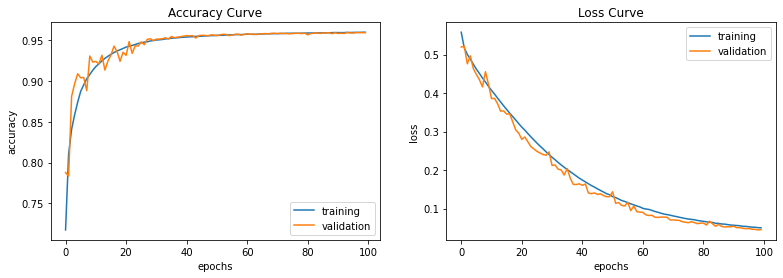

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [16]:
train_dice = history.history['dsc']
valid_dice = history.history['val_dsc']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

In [17]:
from numpy import savetxt
savetxt('train_dice.csv', train_dice, delimiter=',')
savetxt('valid_dice.csv', valid_dice, delimiter=',')

savetxt('train_IOU.csv', train_IOU, delimiter=',')
savetxt('valid_IOU.csv', valid_IOU, delimiter=',')

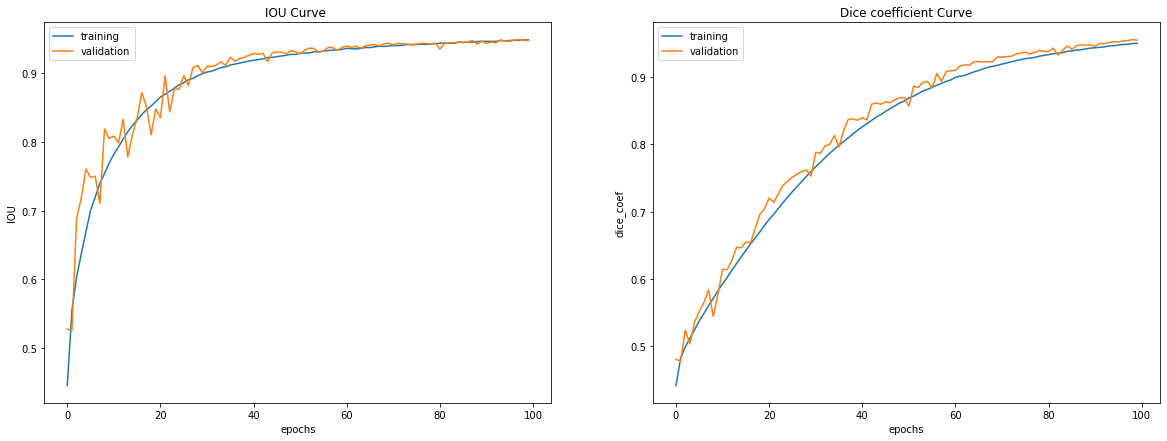

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve ')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()